# Mole detection

In this notebook, we'll create a Convutional Neural Network model in order to classify pictures of moles as either _malignant_ or _benign_.

We'll do that step by step.

First let's import all the packages and modules that will be used in this notebook.

In [1]:
import os
import itertools

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout,Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16, mobilenet_v2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score

import cv2

You can run this notebook with Google Colab (for instance if you want to use the GPU/TPU executions enhancements that they offer).

If you decide to do this, make sure to have downloaded the correct labeled dataset at the root of your Google Drive, in order to be able to use this notebook without modifying paths.

The code below is just to test if we are indeed running inside Colab.

In [2]:
try:
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False

We make sure to use our GPU if we have one.

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


We define the base for the subsquent paths based on wether we run thos on Colab or on a local machine

In [4]:
if IN_COLAB:
    drive.mount('/content/drive/')
    base_path = '/content/drive/MyDrive'
else:
    base_path = './data'

We define the paths from which we'll pick the images.

In [5]:
# paths definition
dataset_path = os.path.join(base_path, 'labeled_dataset')
train_path = os.path.join(dataset_path, 'train')
valid_path = os.path.join(dataset_path, 'valid')
test_path = os.path.join(dataset_path, 'test')

For this project, we've decided to use Transfer Learning in order to take advantage of already well trained image classifiers.

We chose to use MobileNet V2 which is trained on imagenet dataset like VGG16. Even tough VGG16 can perform a bit better in general, we decided to chose MobilNet because of its "lighweightness" and the fact that it is more quickly trainable.

Now let's define some constants for our models.

In [6]:
# model constants definition
CLASSES = ['malignant', 'benign']
INPUT_SIZE = (224, 224)
INPUT_SHAPE = INPUT_SIZE + (3,)
BATCH_SIZE = 32
EPOCHS = 40

The following function is a pre-processing function which will be applied to every image before being fed as an input to the model. 
It is just the standard MobilNet V2 input processing function with a bilateral filter applied just before.

In [7]:
def preprocess_mobilenetV2(image):
  image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
  image = mobilenet_v2.preprocess_input(image, data_format=None)
  return image


Let's define three generators based on our specific file hierarchy. One for each of these categories: training set, validation set and testing set.

We use the preprocessing function defined above for the three generators of batches.

We augment the training data a bit to make act against overfitting and we shuffle all the data except the testing data since we need a fixed order to evaluate our model at the end.

In [19]:
train_batches = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.1, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    vertical_flip=True,
    preprocessing_function=preprocess_mobilenetV2).flow_from_directory(
        train_path, 
        target_size=INPUT_SIZE, 
        classes=CLASSES, 
        shuffle = True,
        batch_size=BATCH_SIZE)
valid_batches = ImageDataGenerator(
    preprocessing_function=preprocess_mobilenetV2).flow_from_directory(
        valid_path, 
        target_size=INPUT_SIZE, 
        classes=CLASSES,
        shuffle = True,
        batch_size=BATCH_SIZE)
test_batches = ImageDataGenerator(
    preprocessing_function=preprocess_mobilenetV2).flow_from_directory(
        test_path, 
        target_size=INPUT_SIZE, 
        classes=CLASSES, 
        shuffle = False,
        batch_size=BATCH_SIZE)

Found 2177 images belonging to 2 classes.
Found 434 images belonging to 2 classes.
Found 289 images belonging to 2 classes.


The following function plots the next batch of preprocessed training data and then return the images/labels.

In [9]:
def next_images_batch_and_plot(ims_batch, figsize=(12,6), rows=1, interp=False):
    class_dict = ims_batch.class_indices

    ims, labels = next(ims_batch)

    titles = ['benign' if x[class_dict['benign']]==1 else 'malignant' for x in labels]

    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)#.astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
    
    return ims, labels

Let's use it as a test on the first batch to see what the training images look like after preprocessing and augmentation.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

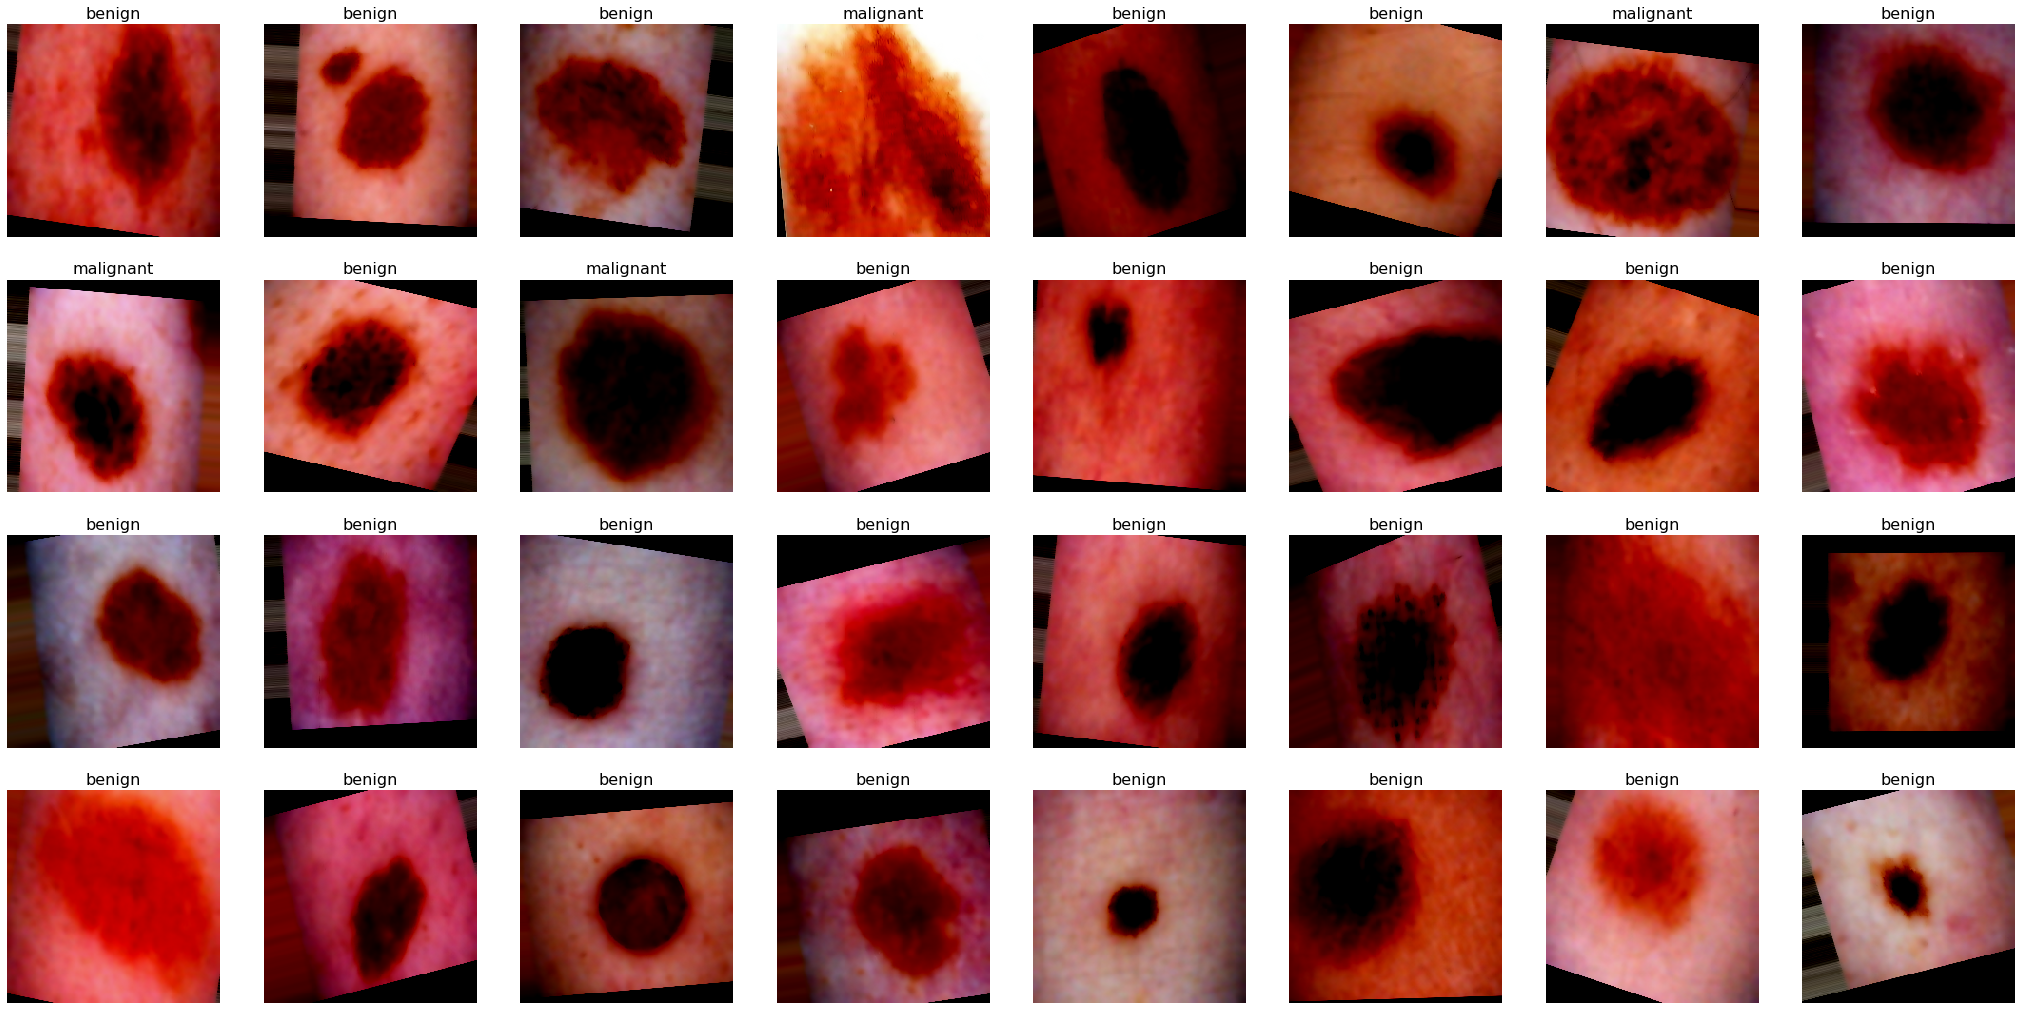

In [20]:
ims, labels = next_images_batch_and_plot(train_batches, figsize=(36,18), rows=4)

It is now time to build the model based on MobilNet V2 !

In [21]:
model = Sequential()
base_model = mobilenet_v2.MobileNetV2(weights='imagenet',include_top=False, input_shape=INPUT_SHAPE)
model.add(base_model)
model.layers[0].summary()

_relu[0][0]        
__________________________________________________________________________________________________
block_6_depthwise (DepthwiseCon (None, 14, 14, 192)  1728        block_6_pad[0][0]                
__________________________________________________________________________________________________
block_6_depthwise_BN (BatchNorm (None, 14, 14, 192)  768         block_6_depthwise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 14, 14, 192)  0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 14, 14, 64)   12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 14, 14, 64)   256         block_6_project[0][0]   

We add a dense layer, a dropout layer (against overfitting) and a final dense layer of two units: one for a malignant mole and one for a benign one.

In [22]:
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               16056576  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 18,315,074
Trainable params: 18,280,962
Non-trainable params: 34,112
_________________________________________________________________


The purpose is to take advantage of the pre-trained MobilNet, so we will make its parameters non-trainable.

In [23]:
for layers in model.layers[0].layers:
  layers.trainable = False

model.layers[0].trainable = False

Here is a summary of our final model.

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               16056576  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 18,315,074
Trainable params: 16,057,090
Non-trainable params: 2,257,984
_________________________________________________________________


Let's compile and train it.

In [25]:
model.compile(optimizer = Adam(learning_rate= 0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [26]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [27]:
model.fit(train_batches, 
          steps_per_epoch=len(train_batches.filenames)//BATCH_SIZE, 
          epochs=EPOCHS, 
          validation_data=valid_batches, 
          validation_steps=len(test_batches.filenames)//BATCH_SIZE, 
          class_weight = {0:3, 1:1}, 
        #   callbacks=[es],
          verbose=1,
          )

Epoch 1/40
68/68 [==============================] - 126s 2s/step - loss: 1.8402 - accuracy: 0.6444 - val_loss: 0.4858 - val_accuracy: 0.7743
Epoch 2/40
68/68 [==============================] - 30s 441ms/step - loss: 0.9424 - accuracy: 0.6678 - val_loss: 0.5443 - val_accuracy: 0.7049
Epoch 3/40
68/68 [==============================] - 28s 415ms/step - loss: 0.8207 - accuracy: 0.7435 - val_loss: 0.5015 - val_accuracy: 0.7500
Epoch 4/40
68/68 [==============================] - 28s 414ms/step - loss: 0.8566 - accuracy: 0.7247 - val_loss: 0.4134 - val_accuracy: 0.8194
Epoch 5/40
68/68 [==============================] - 29s 418ms/step - loss: 0.8453 - accuracy: 0.7305 - val_loss: 0.4974 - val_accuracy: 0.7639
Epoch 6/40
68/68 [==============================] - 29s 422ms/step - loss: 0.7547 - accuracy: 0.7571 - val_loss: 0.4873 - val_accuracy: 0.7604
Epoch 7/40
68/68 [==============================] - 30s 432ms/step - loss: 0.8437 - accuracy: 0.7111 - val_loss: 0.4519 - val_accuracy: 0.7778
E

Based on the training history we plots the learning curves.

In [29]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

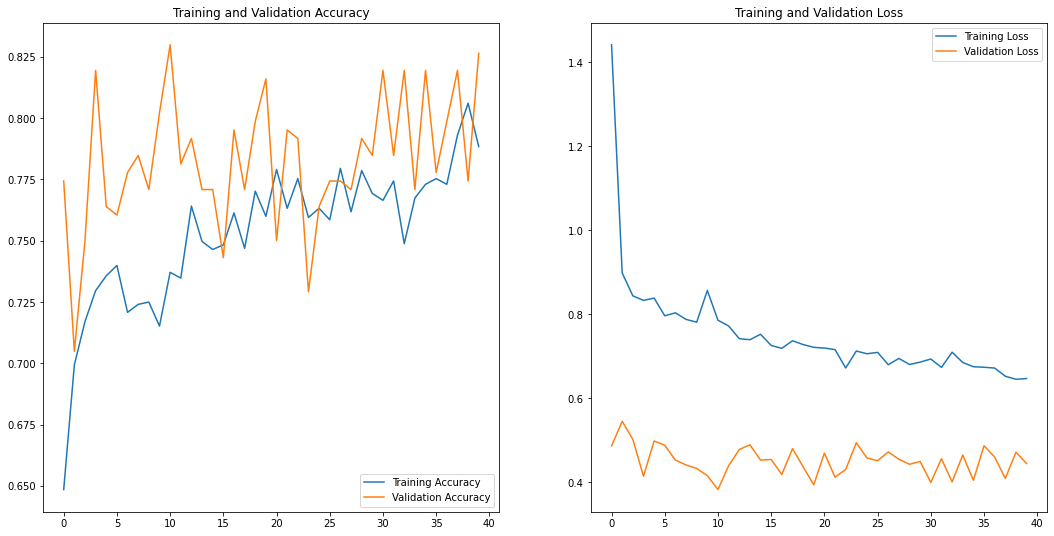

In [30]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Now let's use our segregated test set to evaluate this model with the accuracy and a confusion matrix.

In [31]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [32]:
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes

array([1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1])

In [33]:
true_classes = test_batches.classes
true_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1], dtype=int32)

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 30  32]
 [ 33 194]]


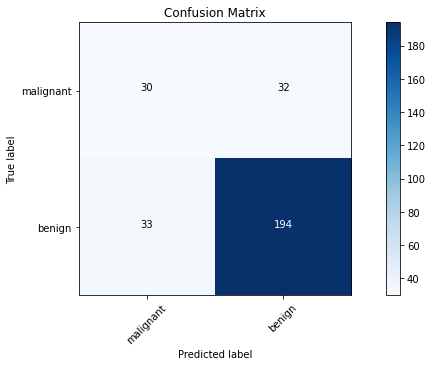

In [35]:
cm = confusion_matrix(y_true=true_classes, y_pred=predicted_classes)
cm_plot_labels = ['malignant', 'benign']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [36]:
print(f'Accuracy: {accuracy_score(predicted_classes, true_classes) * 100}%')

Accuracy: 77.50865051903114%


In [37]:
model.save('modelv1.h5')